In [90]:
%load_ext autoreload
%autoreload 2

import sys
import random
import pickle
import math
import os
import os.path as osp
import json
from functools import partial
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics as skl
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import emmental
from emmental import Meta
from emmental.data import EmmentalDataset
from emmental.data import EmmentalDataLoader
from emmental.learner import EmmentalLearner
from emmental.model import EmmentalModel
from emmental.scorer import Scorer
from emmental.task import EmmentalTask

from collections import defaultdict, namedtuple
import torch
import torch.utils.data as data
from torchvision.models import densenet121
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
import torchvision.transforms as transforms
from scipy.ndimage.filters import gaussian_filter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
emmental.init()
Meta.update_config({
    'model_config': {
        'device': -1,
        'dataparallel': False
    }
})
Meta.config

[2019-12-08 19:57:28,020][INFO] emmental.meta:110 - Logging was already initialized to use /tmp/2019_12_08/19_57_15/907906c3.  To configure logging manually, call emmental.init_logging before initialiting Meta.
[2019-12-08 19:57:28,064][INFO] emmental.meta:60 - Loading Emmental default config from /lfs/1/gangus/repositories/pytorch-classification/emmental/src/emmental/emmental-default-config.yaml.
[2019-12-08 19:57:28,066][INFO] emmental.meta:160 - Updating Emmental config from user provided config.


{'meta_config': {'seed': None, 'verbose': True, 'log_path': 'logs'},
 'data_config': {'min_data_len': 0, 'max_data_len': 0},
 'model_config': {'model_path': None, 'device': -1, 'dataparallel': False},
 'learner_config': {'fp16': False,
  'n_epochs': 1,
  'train_split': ['train'],
  'valid_split': ['valid'],
  'test_split': ['test'],
  'ignore_index': None,
  'optimizer_config': {'optimizer': 'adam',
   'lr': 0.001,
   'l2': 0.0,
   'grad_clip': None,
   'asgd_config': {'lambd': 0.0001, 'alpha': 0.75, 't0': 1000000.0},
   'adadelta_config': {'rho': 0.9, 'eps': 1e-06},
   'adagrad_config': {'lr_decay': 0,
    'initial_accumulator_value': 0,
    'eps': 1e-10},
   'adam_config': {'betas': (0.9, 0.999), 'eps': 1e-08, 'amsgrad': False},
   'adamw_config': {'betas': (0.9, 0.999), 'eps': 1e-08, 'amsgrad': False},
   'adamax_config': {'betas': (0.9, 0.999), 'eps': 1e-08},
   'lbfgs_config': {'max_iter': 20,
    'max_eval': None,
    'tolerance_grad': 1e-07,
    'tolerance_change': 1e-09,
    'h

In [115]:
class CIFAR100(VisionDataset):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        superclass (int, optinoal): If 0, use fine labels; else use coarse labels
        subsample_subclass (dict, optional): string-float key-value pairs indicating
            subclass to subsample and fraction of that subclass to retain at train time
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]

    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False, superclass=False, subsample_subclass={}, whiten_subclass={},
                 diff_subclass={}, switch_subclass={}, verbose=False):

        super().__init__(root, transform=transform, target_transform=target_transform)
        printv = print if verbose else lambda *args, **kwargs: None

        self.train = train  # training set or test set
        self.superclass = superclass  # use superclass labels for training

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        # Setting meta
        if self.superclass:
            self.target_key = 'coarse_label',
            printv('Using coarse labels...')
        else:
            self.target_key = 'fine_label'
            printv('Using fine labels...')

        if isinstance(self.target_key, tuple):
            self.target_key = self.target_key[0]

        self.meta = {
            'filename': 'meta',
            'target_key': f'{self.target_key}_names',
            'md5': '7973b15100ade9c7d40fb424638fde48',
        }

        file_path = os.path.join(
            self.root, self.base_folder, 'train' if train else 'test')
        with open(file_path, 'rb') as f:
            if sys.version_info[0] == 2:
                self.data = pickle.load(f)
            else:
                self.data = pickle.load(f, encoding='latin1')

        self.data['data'] = np.vstack(self.data['data']).reshape(-1, 3, 32, 32)
        self.data['data'] = self.data['data'].transpose(
            (0, 2, 3, 1))  # convert to HWC

        self._load_meta()

        # Subsampling subclasses
        if subsample_subclass is not {}:
            for ky, val in subsample_subclass.items():
                printv(
                    f'Subsampling {ky} fine class, keeping {val*100} percent...')
                inds = [i for i, x in enumerate(
                    self.data['fine_labels']) if x == self.fine_class_to_idx[ky]]
                inds = random.sample(inds, int((1-val)*len(inds)))
                for k in self.data.keys():
                    self.data[k] = [i for j, i in enumerate(
                        self.data[k]) if j not in inds]

        # Whitening subclasses
        if whiten_subclass is not {}:
            unique_coarse_labels = list(set(self.data['coarse_labels']))
            for ky, val in whiten_subclass.items():
                printv(
                    f'Whitening {ky} fine class, keeping {val*100} percent...')
                inds = [i for i, x in enumerate(
                    self.data['fine_labels']) if x == self.fine_class_to_idx[ky]]
                inds = random.sample(inds, int((1-val)*len(inds)))
                for ii, _ in enumerate(self.data['coarse_labels']):
                    if ii in inds:
                        self.data['coarse_labels'][ii] = random.choice(
                            unique_coarse_labels)

        # Making difficult-to-discriminate subclasses
        if diff_subclass is not {}:
            for class_1, class_2 in diff_subclass.items():
                printv(f'Replacing class {class_1} with blurred {class_2}...')
                inds_c1 = [i for i, x in enumerate(
                    self.data['fine_labels']) if x == self.fine_class_to_idx[class_1]]
                inds_c2 = [i for i, x in enumerate(
                    self.data['fine_labels']) if x == self.fine_class_to_idx[class_2]]
                for ii, ind in enumerate(inds_c1):
                    self.data['data'][ind] = gaussian_filter(
                        self.data['data'][inds_c2[ii]], sigma=1.25)

        if switch_subclass is not {}:
            for class_1, class_2 in switch_subclass.items():
                printv(f'Swapping {class_1} with {class_2}...')
                inds_c1 = [i for i, x in enumerate(
                    self.data['fine_labels']) if x == self.fine_class_to_idx[class_1]]
                inds_c2 = [i for i, x in enumerate(
                    self.data['fine_labels']) if x == self.fine_class_to_idx[class_2]]
                coarse_c1 = self.data['coarse_labels'][inds_c1[0]]
                coarse_c2 = self.data['coarse_labels'][inds_c2[0]]
                for ind in inds_c1:
                    self.data['coarse_labels'][ind] = coarse_c2
                for ind in inds_c2:
                    self.data['coarse_labels'][ind] = coarse_c1

        fine_labels, coarse_labels = torch.tensor(
            self.data['fine_labels']), torch.tensor(self.data['coarse_labels'])
        self.num_subclasses = torch.max(fine_labels).item() + 1
        self.num_supclasses = torch.max(coarse_labels).item() + 1
        subclass_map = (fine_labels == torch.arange(
            self.num_subclasses).unsqueeze(1).long()).float()
        self.subclass_counts = subclass_map.sum(1)
        supclass_map = (coarse_labels == torch.arange(
            self.num_supclasses).unsqueeze(1).long()).float()
        self.supclass_counts = supclass_map.sum(1)

    def _load_meta(self):
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
        if not check_integrity(path, self.meta['md5']):
            raise RuntimeError('Dataset metadata file not found or corrupted.' +
                               ' You can use download=True to download it')
        with open(path, 'rb') as infile:
            if sys.version_info[0] == 2:
                data = pickle.load(infile)
            else:
                data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['target_key']]
        self.class_to_idx = {_class: i for i,
                             _class in enumerate(self.classes)}
        self.fine_class_to_idx = {_class: i for i,
                                  _class in enumerate(data['fine_label_names'])}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        item_data = {
            'fine_label': self.data['fine_labels'][index],
            'coarse_label': self.data['coarse_labels'][index],
            'filename': self.data['filenames'][index],
        }

        img, target = self.data['data'][index], item_data[self.target_key]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        item_data['target'] = target
        item_data['img'] = img

        return item_data

    def __len__(self):
        return len(self.data['data'])

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        download_and_extract_archive(
            self.url, self.root, filename=self.filename, md5=self.tgz_md5)

    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")


class EmmentalCIFAR100(EmmentalDataset):

    def __init__(self, root, train, transform, target_transform, download,
                 superclass=False, subsample_subclass={}, whiten_subclass={},
                 diff_subclass={}, switch_subclass={}, verbose=False):
        """
        """
        self.dataset = CIFAR100(
            root, train, transform=None, target_transform=None, download=download,
            superclass=superclass, subsample_subclass=subsample_subclass, whiten_subclass=whiten_subclass,
            diff_subclass=diff_subclass, switch_subclass=switch_subclass, verbose=verbose)

        # transforms
        self.transform = transform
        self.target_transform = target_transform

        # superclass analysis
        self.classes = self.dataset.classes
        self.num_subclasses = self.dataset.num_subclasses
        self.num_supclasses = self.dataset.num_supclasses
        self.subclass_counts = self.dataset.subclass_counts
        self.supclass_counts = self.dataset.supclass_counts

        # metadata
        self.class_to_idx = self.dataset.class_to_idx
        self.fine_class_to_idx = self.dataset.fine_class_to_idx

        # emmental init
        X_dict = {'image_a': [], 'filename_a': []}
        Y_dict = {'subclass_a': [], 'superclass': []}

        self.superclass_to_idxs = defaultdict(list)
        for idx, item in enumerate(self.dataset):
            X_dict['image_a'].append(item['img'])
            X_dict['filename_a'].append(item['filename'])

            Y_dict['subclass_a'].append(item['fine_label'])
            Y_dict['superclass'].append(item['coarse_label'])
            
            self.superclass_to_idxs[int(item['coarse_label'])].append(idx)

        for k, v in Y_dict.items():
            Y_dict[k] = torch.from_numpy(np.array(v))

        del self.dataset
        EmmentalDataset.__init__(
            self, 'CIFAR100', X_dict=X_dict, Y_dict=Y_dict, uid='filename_a')

    def __getitem__(self, idx):
        """
        """
        x_dict = {k: v[idx] for k, v in self.X_dict.items()}
        y_dict = {k: v[idx] for k, v in self.Y_dict.items()}

        image_a = x_dict['image_a']
        superclass = y_dict['superclass']

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        image_a = Image.fromarray(image_a)
        if self.transform is not None:
            image_a = self.transform(image_a)

        if self.target_transform is not None:
            superclass = self.target_transform(superclas)

        x_dict['image_a'] = image_a
        y_dict['superclass'] = superclass

        return x_dict, y_dict


class IIC_CIFAR100(EmmentalCIFAR100):

    def __init__(self, root, train, transform, target_transform, download,
                 superclass=False, subsample_subclass={}, whiten_subclass={},
                 diff_subclass={}, switch_subclass={}, verbose=False,
                 pair_type='augment', pair_transform=None):
        """
        """
        assert pair_type in {
            'augment', 'subclass'}, f'pair_type {pair_type} must be in "augment", "subclass"'

        super().__init__(root, train, transform, target_transform, download,
                         superclass=superclass, subsample_subclass=subsample_subclass,
                         whiten_subclass=whiten_subclass, diff_subclass=diff_subclass,
                         switch_subclass=switch_subclass, verbose=verbose)
        self.pair_type = pair_type
        self.pair_transform = pair_transform

    def __getitem__(self, idx):
        """
        """
        x_dict = {k: v[idx] for k, v in self.X_dict.items()}
        y_dict = {k: v[idx] for k, v in self.Y_dict.items()}

        if self.transform:
            x_dict['image_a'] = self.transform(x_dict['image_a'])
        if self.pair_type == 'augment':
            x_dict['image_b'] = self.pair_transform(x_dict['image_a'])
            if self.transform:
                x_dict['image_b'] = self.transform(x_dict['image_b'])
            x_dict['filename_b'] = x_dict['filename_a']
            y_dict['subclass_b'] = y_dict['subclass_a']
        elif self.pair_type == 'subclass':
            b_idx = random.sample(self.superclass_to_idxs[y_dict['superclass']], 1)[0]
            x_dict['image_b'] = self.X_dict['image_a'][b_idx]
            if self.transform:
                x_dict['image_b'] = self.transform(x_dict['image_b'])
            x_dict['filename_b'] = self.X_dict['filename_a'][b_idx]
            y_dict['subclass_b'] = self.Y_dict['subclass_a'][b_idx]

        return x_dict, y_dict


In [236]:
dataset = IIC_CIFAR100(
    root='/lfs/1/gangus/data',
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]),
    target_transform=None,
    download=False,
    superclass=True,
    pair_type='subclass',
    pair_transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(), 
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
)

In [237]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
idx_to_fine_class = {v: k for k, v in dataset.fine_class_to_idx.items()}

In [247]:
idx = 60
x, y = dataset[idx]

16 small_mammals
36 hamster


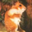

In [248]:
coarse_label = int(y['superclass'])
print(coarse_label, idx_to_class[coarse_label])
fine_label = int(y['subclass_a'])
print(fine_label, idx_to_fine_class[fine_label])
Image.fromarray(np.array(x['image_a'].permute(1, 2, 0) * 255, dtype=np.uint8), 'RGB')

16 small_mammals
74 shrew


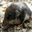

In [249]:
coarse_label = int(y['superclass'])
print(coarse_label, idx_to_class[coarse_label])
fine_label = int(y['subclass_b'])
print(fine_label, idx_to_fine_class[fine_label])
Image.fromarray(np.array(x['image_b'].permute(1, 2, 0) * 255, dtype=np.uint8), 'RGB')

In [17]:
task_names = ['superclass', 'iid']
task_to_label_dict = {k: 'superclass' for k in task_names}
split = 'train'
dataloader = EmmentalDataLoader(
    task_to_label_dict=task_to_label_dict,
    dataset=dataset,
    split=split,
    shuffle=True if split == 'train' else False,
    batch_size=4,
    num_workers=4
)

In [33]:
def ce_loss(task_name, immediate_output_dict, Y, active):
    module_name = f"{task_name}_pred_head"
    return F.cross_entropy(
        immediate_output_dict[module_name][0][active], Y.view(-1)[active]
    )
    

def output(task_name, immediate_output_dict):
    module_name = f"{task_name}_pred_head"
    return immediate_output_dict[module_name][0]


def pair_loss_iid(task_name, immediate_output_dict, Y, active, 
             lamb=1.0, EPS=sys.float_info.epsilon):
    module_name = f"{task_name}_pred_head"
    x_out, x_tf_out = [F.softmax(x, dim=-1) for x in immediate_output_dict[module_name]]
    
    # has had softmax applied
    _, k = x_out.size()
    p_i_j = compute_joint(x_out, x_tf_out)
    assert (p_i_j.size() == (k, k))

    p_i = p_i_j.sum(dim=1).view(k, 1).expand(k, k)
    p_j = p_i_j.sum(dim=0).view(1, k).expand(k, k)  # but should be same, symmetric

    # avoid NaN losses. Effect will get cancelled out by p_i_j tiny anyway
    p_i_j[(p_i_j < EPS).data] = EPS
    p_j[(p_j < EPS).data] = EPS
    p_i[(p_i < EPS).data] = EPS

    loss = - p_i_j * (torch.log(p_i_j) \
                      - lamb * torch.log(p_j) \
                      - lamb * torch.log(p_i))

    loss = loss.sum()

    loss_no_lamb = - p_i_j * (torch.log(p_i_j) \
                              - torch.log(p_j) \
                              - torch.log(p_i))

    loss_no_lamb = loss_no_lamb.sum()

    return loss# , loss_no_lamb


def pair_output(task_name, immediate_output_dict):
    module_name = f"{task_name}_pred_head"
    return torch.stack(immediate_output_dict[module_name], dim=2)

def compute_joint(x_out, x_tf_out):
    # produces variable that requires grad (since args require grad)

    bn, k = x_out.size()
    assert (x_tf_out.size(0) == bn and x_tf_out.size(1) == k)

    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)  # bn, k, k
    p_i_j = p_i_j.sum(dim=0)  # k, k
    p_i_j = (p_i_j + p_i_j.t()) / 2.  # symmetrise
    p_i_j = p_i_j / p_i_j.sum()  # normalise

    return p_i_j

In [34]:
class ClippedDenseNet(nn.Module):
    
    def __init__(self, n_classes=14, pretrained=True, weights_path=None):
        """
        """
        super().__init__()
        self.densenet121 = densenet121(pretrained=pretrained)
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(self.densenet121.classifier.in_features, n_classes),
            nn.Sigmoid()
        )
        
        # TODO: get this to work
        if weights_path:
            state_dict = torch.load(weights_path)['state_dict']
            state_dict = {k.replace('module.densenet121', 'densenet121'): v for k, v in state_dict.items()}
            state_dict = {k.replace('.norm.1', '.norm1'): v for k, v  in state_dict.items()}
            state_dict = {k.replace('.norm.2', '.norm2'): v for k, v  in state_dict.items()}
            state_dict = {k.replace('.conv.1', '.conv1'): v for k, v  in state_dict.items()}
            state_dict = {k.replace('.conv.2', '.conv2'): v for k, v  in state_dict.items()}
            self.load_state_dict(state_dict, strict=False)
            num_loaded = len(set(self.state_dict().keys()) & set(state_dict.keys()))
            num_total = len(state_dict.keys())
            if num_loaded < num_total:
                missing_params = set(state_dict.keys()).symmetric_difference(set(self.state_dict().keys()))
                logging.info("Could not load these parameters due to name mismatch: " + str(missing_params))
            logging.info(f"Loaded {num_loaded}/{num_total} pretrained parameters")
            
        self.densenet121.classifier = nn.Identity()
        
    def forward(self, x1, x2=None):
        """
        """
        if x2 is None:
            return self.densenet121(x1)
        else:
            return self.densenet121(x1), self.densenet121(x2)
        
class ClusterModule(nn.Module):
    
    def __init__(self, in_features=1024, out_features=100):
        """
        """
        super().__init__()
        self.classifier = nn.Linear(in_features, out_features)
        
    def forward(self, x1, x2=None):
        if x2 is None:
            return self.classifier(x1)
        else:
            return self.classifier(x1), self.classifier(x2)

In [35]:
encoder_module = ClippedDenseNet(n_classes=14, pretrained=False, weights_path=None)
decoder_module = nn.Linear(1024, 20)
cluster_module = ClusterModule(1024, 100)

tasks = [      
    EmmentalTask(
        name='superclass',
        module_pool=nn.ModuleDict({
            'encoder': encoder_module,
            'decoder': decoder_module
        }),
        task_flow=[
            {
                'name': 'encoder',
                'module': 'encoder',
                'inputs': [('_input_', 'image_a'), ('_input_', 'image_b')]
            },
            {
                'name': 'superclass_pred_head',
                'module': 'decoder',
                'inputs': [('encoder', 0)]
            }
        ],
        loss_func=partial(ce_loss, 'superclass'),
        output_func=partial(output, 'superclass'),
        scorer=Scorer(metrics=["accuracy"]),
    ),
    EmmentalTask(
        name='iid',
        module_pool=nn.ModuleDict({
            'encoder': encoder_module,
            'cluster': cluster_module
        }),
        task_flow=[
            {
                'name': 'encoder',
                'module': 'encoder',
                'inputs': [('_input_', 'image_a'), ('_input_', 'image_b')]
            },
            {
                'name': 'iid_pred_head',
                'module': 'cluster',
                'inputs': [('encoder', 0), ('encoder', 1)]
            }
        ],
        loss_func=partial(pair_loss_iid, 'iid'),
        output_func=partial(pair_output, 'iid'),
        scorer=Scorer(metrics=[]),
    )
]

[2019-12-08 19:59:35,460][INFO] emmental.task:48 - Created task: superclass
[2019-12-08 19:59:35,462][INFO] emmental.task:48 - Created task: iid


In [36]:
model = EmmentalModel(name='IIC', tasks=tasks)

[2019-12-08 19:59:35,592][INFO] emmental.model:57 - Created emmental model IIC that contains task {'superclass', 'iid'}.


In [38]:
model.predict(dataloader)